In [ ]:
#hide
#skip
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

In [ ]:
#default_exp torch_core

In [ ]:
#export
from fastai.imports import *
from fastai.torch_imports import *

In [ ]:
from PIL import Image

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
_all_ = ['progress_bar','master_bar']

In [ ]:
#export
if torch.cuda.is_available():
    if torch.cuda.current_device()==0:
        def_gpu = int(os.environ.get('DEFAULT_GPU') or 0)
        if torch.cuda.device_count()>=def_gpu: torch.cuda.set_device(def_gpu)
    torch.backends.cudnn.benchmark = True

# Torch Core

> Basic pytorch functions used in the fastai library

## Arrays and show

In [ ]:
#export
@delegates(plt.subplots, keep=True)
def subplots(nrows=1, ncols=1, figsize=None, imsize=3,suptitle=None, **kwargs):
    if figsize is None: 
        h=nrows*imsize if suptitle is None or imsize>2 else nrows*imsize+0.6 #https://github.com/matplotlib/matplotlib/issues/5355
        figsize=(ncols*imsize, h)
    fig,ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    if suptitle is not None: fig.suptitle(suptitle)
    if nrows*ncols==1: ax = array([ax])
    return fig,ax

In [ ]:
#hide
_,axs = subplots()
test_eq(axs.shape,[1])
plt.close()
_,axs = subplots(2,3)
test_eq(axs.shape,[2,3])
plt.close()

In [ ]:
#export
def _fig_bounds(x):
    r = x//32
    return min(5, max(1,r))

In [ ]:
#export
@delegates(plt.Axes.imshow, keep=True, but=['shape', 'imlim'])
def show_image(im, ax=None, figsize=None, title=None, ctx=None, **kwargs):
    "Show a PIL or PyTorch image on `ax`."
    # Handle pytorch axis order
    if hasattrs(im, ('data','cpu','permute')):
        im = im.data.cpu()
        if im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im,np.ndarray): im=array(im)
    # Handle 1-channel images
    if im.shape[-1]==1: im=im[...,0]

    ax = ifnone(ax,ctx)
    if figsize is None: figsize = (_fig_bounds(im.shape[0]), _fig_bounds(im.shape[1]))
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.axis('off')
    return ax

`show_image` can show PIL images...

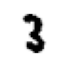

In [ ]:
im = Image.open(TEST_IMAGE_BW)
ax = show_image(im, cmap="Greys")

...and color images with standard `CHW` dim order...

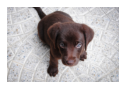

In [ ]:
im2 = np.array(Image.open(TEST_IMAGE))
ax = show_image(im2, figsize=(2,2))

...and color images with `HWC` dim order...

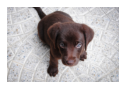

In [ ]:
im3 = torch.as_tensor(im2).permute(2,0,1)
ax = show_image(im3, figsize=(2,2))

In [ ]:
#export
@delegates(show_image, keep=True)
def show_titled_image(o, **kwargs):
    "Call `show_image` destructuring `o` to `(img,title)`"
    show_image(o[0], title=str(o[1]), **kwargs)

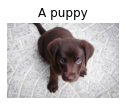

In [ ]:
show_titled_image((im3,'A puppy'), figsize=(2,2))

Show all images `ims` as subplots with `rows` using `titles`. `suptitle` provides a way to create a figure title for all images. If you use `suptitle`, `constrained_layout` is used unless you set `constrained_layout` to `False`. 

In [ ]:
#export
@delegates(subplots)
def show_images(ims, nrows=1, ncols=None, titles=None, **kwargs):
    "Show all images `ims` as subplots with `rows` using `titles`."
    if ncols is None: ncols = int(math.ceil(len(ims)/nrows))
    if titles is None: titles = [None]*len(ims)
    axs = subplots(nrows, ncols, **kwargs)[1].flat
    for im,t,ax in zip(ims, titles, axs): show_image(im, ax=ax, title=t)

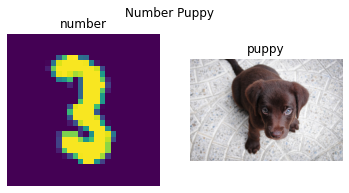

In [ ]:
show_images((im,im3),titles=('number','puppy'),suptitle='Number Puppy',  imsize=3)

`ArrayImage`, `ArrayImageBW` and `ArrayMask` are subclasses of `ndarray` that know how to show themselves.

In [ ]:
#export
class ArrayBase(ndarray):
    "An `ndarray` that can modify casting behavior"
    @classmethod
    def _before_cast(cls, x): return x if isinstance(x,ndarray) else array(x)

In [ ]:
#export
class ArrayImageBase(ArrayBase):
    "Base class for arrays representing images"
    _show_args = {'cmap':'viridis'}
    def show(self, ctx=None, **kwargs):
        return show_image(self, ctx=ctx, **{**self._show_args, **kwargs})

In [ ]:
#export
class ArrayImage(ArrayImageBase):
    "An array representing an image"
    pass

In [ ]:
#export
class ArrayImageBW(ArrayImage):
    "An array representing an image"
    _show_args = {'cmap':'Greys'}

In [ ]:
#export
class ArrayMask(ArrayImageBase):
    "An array representing an image mask"
    _show_args = {'alpha':0.5, 'cmap':'tab20', 'interpolation':'nearest'}

In [ ]:
im = Image.open(TEST_IMAGE)

In [ ]:
im_t = cast(im, ArrayImage)
test_eq(type(im_t), ArrayImage)

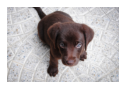

In [ ]:
ax = im_t.show(figsize=(2,2))

In [ ]:
test_fig_exists(ax)

## Basics

In [ ]:
#export
@patch
def __array_eq__(self:Tensor,b):
    return torch.equal(self,b) if self.dim() else self==b

In [ ]:
#export
def _array2tensor(x):
    if x.dtype==np.uint16: x = x.astype(np.float32)
    # windows default numpy int dytpe is int32, while torch tensor default int dtype is int64
    # https://github.com/numpy/numpy/issues/9464
    if sys.platform == "win32":
        if x.dtype==np.int: x = x.astype(np.int64)
    return torch.from_numpy(x)

In [ ]:
#export
@use_kwargs_dict(dtype=None, device=None, requires_grad=False, pin_memory=False)
def tensor(x, *rest, **kwargs):
    "Like `torch.as_tensor`, but handle lists too, and can pass multiple vector elements directly."
    if len(rest): x = (x,)+rest
    # There was a Pytorch bug in dataloader using num_workers>0. Haven't confirmed if fixed
    # if isinstance(x, (tuple,list)) and len(x)==0: return tensor(0)
    res = (x if isinstance(x, Tensor)
           else torch.tensor(x, **kwargs) if isinstance(x, (tuple,list))
           else _array2tensor(x) if isinstance(x, ndarray)
           else as_tensor(x.values, **kwargs) if isinstance(x, (pd.Series, pd.DataFrame))
#            else as_tensor(array(x, **kwargs)) if hasattr(x, '__array__') or is_iter(x)
           else _array2tensor(array(x), **kwargs))
    if res.dtype is torch.float64: return res.float()
    return res

In [ ]:
test_eq(tensor(torch.tensor([1,2,3])), torch.tensor([1,2,3]))
test_eq(tensor(array([1,2,3])), torch.tensor([1,2,3]))
test_eq(tensor(1,2,3), torch.tensor([1,2,3]))
test_eq_type(tensor(1.0), torch.tensor(1.0))

```set_seed``` is useful for reproducibility between runs. It is important to remember that certain classes such as ```Dataloaders``` have internal random number generators that is not effected by this function, so this must be run before such objects are created in order to guarantee reproducibility. 

In [ ]:
#export
def set_seed(s, reproducible=False):
    "Set random seed for `random`, `torch`, and `numpy` (where available)"
    try: torch.manual_seed(s)
    except NameError: pass
    try: torch.cuda.manual_seed_all(s)
    except NameError: pass
    try: np.random.seed(s%(2**32-1))
    except NameError: pass
    random.seed(s)
    if reproducible:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

Here is an example of how ```set_seed``` can be used to reset the state of random number generators.

In [ ]:
set_seed(2*33)
a1 = np.random.random()
a2 = torch.rand(())
a3 = random.random()
set_seed(2*33)
b1 = np.random.random()
b2 = torch.rand(())
b3 = random.random()
print('a\'s: {0:3.3f} {1:3.3f} {2:3.3f}'.format(a1,a2,a3))
print('b\'s: {0:3.3f} {1:3.3f} {2:3.3f}'.format(b1,b2,a3))

a's: 0.154 0.498 0.071
b's: 0.154 0.498 0.071


In [ ]:
test_eq(a1,b1)
test_eq(a2,b2)
test_eq(a3,b3)

```get_random_states``` and ```set_random_states``` are useful for storing a state so you can go back to it later. 

In [ ]:
#export
def get_random_states():
    "Gets states for `random`, `torch`, and `numpy` random number generators"
    return {'random_state':random.getstate(),
            'numpy_state':np.random.get_state(),
            'torch_state':torch.get_rng_state(),
            'torch_cuda_state':torch.cuda.get_rng_state_all(),
            'torch_deterministic':torch.backends.cudnn.deterministic,
            'torch_benchmark':torch.backends.cudnn.benchmark}

In [ ]:
#export
def set_random_states(random_state,numpy_state,torch_state,torch_cuda_state,torch_deterministic,torch_benchmark):
    "Set states for `random`, `torch`, and `numpy` random number generators"
    random.setstate(random_state)
    np.random.set_state(numpy_state)
    torch.set_rng_state(torch_state)
    torch.cuda.set_rng_state_all(torch_cuda_state)
    torch.backends.cudnn.deterministic=torch_deterministic
    torch.backends.cudnn.benchmark=torch_benchmark

Below notice that the old values and rewinded values are the same because we were able to return to the previous state. 

In [ ]:
old_states = get_random_states()
olds = (random.random(),np.random.random(),torch.rand(()))
news = (random.random(),np.random.random(),torch.rand(()))
set_random_states(**old_states)
rewinds = (random.random(),np.random.random(),torch.rand(()))

print('olds:    {0:3.3f} {1:3.3f} {2:3.3f}'.format(*olds))
print('news:    {0:3.3f} {1:3.3f} {2:3.3f}'.format(*news))
print('rewinds: {0:3.3f} {1:3.3f} {2:3.3f}'.format(*rewinds))

olds:    0.435 0.134 0.023
news:    0.246 0.363 0.227
rewinds: 0.435 0.134 0.023


In [ ]:
test_ne(olds,news)
test_eq(olds,rewinds)

In ```no_random``` we combine the ideas of rewinding state with ```get_random_states``` and ```set_random_states``` with the ability to ```set_seed``` and create a context manager that can allow us to control randomness in a portion of our code. 

Note: Similar to ```torch.random.fork_rng```, but also with ```numpy``` and ```random```

In [ ]:
#export
@contextmanager
def no_random(seed=42,reproducible=True):
    "Stores and retrieves state of random number generators. Sets random seed for `random`, `torch`, and `numpy`."
    states = get_random_states()
    set_seed(seed,reproducible=reproducible)
    try:
        yield #we are managing global variables
    finally:
        set_random_states(**states)

Here are some examples on how we can use ```no_random``` to control the randomness within a block of code.  

In [ ]:
states=get_random_states()
olds = (random.random(),np.random.random(),torch.rand(()))
set_random_states(**states) #rewinding above random calls

with no_random():
    new1 = (random.random(),np.random.random(),torch.rand(()))
with no_random():
    new2 = (random.random(),np.random.random(),torch.rand(()))
with no_random(seed=100):
    seeded1 = (random.random(),np.random.random(),torch.rand(()))
with no_random(seed=100):
    seeded2 = (random.random(),np.random.random(),torch.rand(()))
        
rewinds = (random.random(),np.random.random(),torch.rand(()))

print('olds:    {0:3.3f} {1:3.3f} {2:3.3f}'.format(*olds))
print('new1:    {0:3.3f} {1:3.3f} {2:3.3f}'.format(*new1))
print('new2:    {0:3.3f} {1:3.3f} {2:3.3f}'.format(*new2))
print('seeded1: {0:3.3f} {1:3.3f} {2:3.3f}'.format(*seeded1))
print('seeded2: {0:3.3f} {1:3.3f} {2:3.3f}'.format(*seeded2))
print('rewinds: {0:3.3f} {1:3.3f} {2:3.3f}'.format(*rewinds))

olds:    0.246 0.363 0.227
new1:    0.639 0.375 0.882
new2:    0.639 0.375 0.882
seeded1: 0.146 0.543 0.112
seeded2: 0.146 0.543 0.112
rewinds: 0.246 0.363 0.227


Notice that olds, and rewinds are alos both equal to each other. From this  we can see that everything in the ```with``` blocks did not update the state outside of the block. Inside of the block, the state is reset for any particular seed, so for the same seed you should get the same random number generator results.  

Note: It is important to remember that classes like ``` Dataloader``` have internal random number generators, and ```no_random``` will have no effect on those random number generators.

In [ ]:
test_ne(olds,new1)
test_eq(new1,new2)
test_ne(new1,seeded1)
test_eq(seeded1,seeded2)
test_eq(olds,rewinds)

In [ ]:
#export
def unsqueeze(x, dim=-1, n=1):
    "Same as `torch.unsqueeze` but can add `n` dims"
    for _ in range(n): x = x.unsqueeze(dim)
    return x

In [ ]:
t = tensor([1])
t2 = unsqueeze(t, n=2)
test_eq(t2,t[:,None,None])

In [ ]:
#export
def unsqueeze_(x, dim=-1, n=1):
    "Same as `torch.unsqueeze_` but can add `n` dims"
    for _ in range(n): x.unsqueeze_(dim)
    return x

In [ ]:
t = tensor([1])
unsqueeze_(t, n=2)
test_eq(t, tensor([1]).view(1,1,1))

In [ ]:
#export
def _fa_rebuild_tensor (cls, *args, **kwargs): return cls(torch._utils._rebuild_tensor_v2(*args, **kwargs))
def _fa_rebuild_qtensor(cls, *args, **kwargs): return cls(torch._utils._rebuild_qtensor  (*args, **kwargs))

In [ ]:
#export
def apply(func, x, *args, **kwargs):
    "Apply `func` recursively to `x`, passing on args"
    if is_listy(x): return type(x)([apply(func, o, *args, **kwargs) for o in x])
    if isinstance(x,dict):  return {k: apply(func, v, *args, **kwargs) for k,v in x.items()}
    res = func(x, *args, **kwargs)
    return res if x is None else retain_type(res, x)

In [ ]:
#export
def maybe_gather(x, axis=0):
    "Gather copies of `x` on `axis` (if training is distributed)"
    if num_distrib()<=1: return x
    ndim = x.ndim
    res = [x.new_zeros(*x.shape if ndim > 0 else (1,)) for _ in range(num_distrib())]
    torch.distributed.all_gather(res, x.contiguous() if ndim > 0 else x[None])
    return torch.cat(res, dim=axis) if ndim > 0 else torch.cat(res, dim=axis).mean()

In [ ]:
#export
def to_detach(b, cpu=True, gather=True):
    "Recursively detach lists of tensors in `b `; put them on the CPU if `cpu=True`."
    def _inner(x, cpu=True, gather=True):
        if not isinstance(x,Tensor): return x
        x = x.detach()
        if gather: x = maybe_gather(x)
        return x.cpu() if cpu else x
    return apply(_inner, b, cpu=cpu, gather=gather)

`gather` only applies during distributed training and the result tensor will be the one gathered across processes if `gather=True` (as a result, the batch size will be multiplied by the number of processes).

In [ ]:
#export
def to_half(b):
    "Recursively map lists of tensors in `b ` to FP16."
    return apply(lambda x: x.half() if torch.is_floating_point(x) else x, b)

In [ ]:
#export
def to_float(b):
    "Recursively map lists of int tensors in `b ` to float."
    return apply(lambda x: x.float() if torch.is_floating_point(x) else x, b)

In [ ]:
#export
# None: True if available; True: error if not available; False: use CPU
defaults.use_cuda = None

In [ ]:
#export
def default_device(use_cuda=-1):
    "Return or set default device; `use_cuda`: None - CUDA if available; True - error if not available; False - CPU"
    if use_cuda != -1: defaults.use_cuda=use_cuda
    use = defaults.use_cuda or (torch.cuda.is_available() and defaults.use_cuda is None)
    assert torch.cuda.is_available() or not use
    return torch.device(torch.cuda.current_device()) if use else torch.device('cpu')

In [ ]:
# cuda
if torch.cuda.is_available():
    _td = torch.device(torch.cuda.current_device())
    test_eq(default_device(None), _td)
    test_eq(default_device(True), _td)
else:
    test_eq(default_device(False), torch.device('cpu'))
default_device(None);

In [ ]:
#export
def to_device(b, device=None, non_blocking=False):
    "Recursively put `b` on `device`."
    if defaults.use_cuda==False: device='cpu'
    elif device is None: device=default_device()
    def _inner(o):
        if isinstance(o,Tensor): return o.to(device, non_blocking=non_blocking)
#         if hasattr(o, "to_device"): return o.to_device(device)
        return o
    return apply(_inner, b)

In [ ]:
t = to_device((3,(tensor(3),tensor(2))))
t1,(t2,t3) = t

In [ ]:
# cuda
if torch.cuda.is_available():
    test_eq_type(t,(3,(tensor(3).cuda(),tensor(2).cuda())))
    test_eq(t2.type(), "torch.cuda.LongTensor")
    test_eq(t3.type(), "torch.cuda.LongTensor")

In [ ]:
#export
def to_cpu(b):
    "Recursively map lists of tensors in `b ` to the cpu."
    return to_device(b,'cpu')

In [ ]:
t3 = to_cpu(t3)
test_eq(t3.type(), "torch.LongTensor")
test_eq(t3, 2)

In [ ]:
#export
def to_np(x):
    "Convert a tensor to a numpy array."
    return apply(lambda o: o.data.cpu().numpy(), x)

In [ ]:
t3 = to_np(t3)
test_eq(type(t3), np.ndarray)
test_eq(t3, 2)

In [ ]:
#export
def to_concat(xs, dim=0):
    "Concat the element in `xs` (recursively if they are tuples/lists of tensors)"
    if not xs: return xs
    if is_listy(xs[0]): return type(xs[0])([to_concat([x[i] for x in xs], dim=dim) for i in range_of(xs[0])])
    if isinstance(xs[0],dict):  return {k: to_concat([x[k] for x in xs], dim=dim) for k in xs[0].keys()}
    #We may receive xs that are not concatenable (inputs of a text classifier for instance),
    #   in this case we return a big list
    try:    return retain_type(torch.cat(xs, dim=dim), xs[0])
    except: return sum([L(retain_type(o_.index_select(dim, tensor(i)).squeeze(dim), xs[0])
                          for i in range_of(o_)) for o_ in xs], L())

In [ ]:
test_eq(to_concat([tensor([1,2]), tensor([3,4])]), tensor([1,2,3,4]))
test_eq(to_concat([tensor([[1,2]]), tensor([[3,4]])], dim=1), tensor([[1,2,3,4]]))
test_eq_type(to_concat([(tensor([1,2]), tensor([3,4])), (tensor([3,4]), tensor([5,6]))]), (tensor([1,2,3,4]), tensor([3,4,5,6])))
test_eq_type(to_concat([[tensor([1,2]), tensor([3,4])], [tensor([3,4]), tensor([5,6])]]), [tensor([1,2,3,4]), tensor([3,4,5,6])])
test_eq_type(to_concat([(tensor([1,2]),), (tensor([3,4]),)]), (tensor([1,2,3,4]),))

test_eq(to_concat([tensor([[1,2]]), tensor([[3,4], [5,6]])], dim=1), [tensor([1]),tensor([3, 5]),tensor([4, 6])])

In [ ]:
test_eq(type(to_concat([dict(foo=tensor([1,2]), bar=tensor(3,4))])), dict)

## Tensor subtypes

In [ ]:
#export
@patch
def set_meta(self:Tensor, x, as_copy=False):
    "Set all metadata in `__dict__`"
    if not hasattr(x,'__dict__'): return
    # XXX: change to `deepcopy` once PyTorch 1.7.1 is out, and check nb 23 segmentation fit works
    self.__dict__ = copy(x.__dict__) if as_copy else x.__dict__

In [ ]:
#export
if not hasattr(torch,'as_subclass'): torch.as_subclass = torch.Tensor.as_subclass

In [ ]:
#export
@patch
def as_subclass(self:Tensor, typ):
    "Cast to `typ` and include `__dict__` and meta"
    return retain_meta(self, torch.as_subclass(self, typ))

`Tensor.set_meta` and `Tensor.as_subclass` work together to maintain `__dict__` after casting.

In [ ]:
class _T(Tensor): pass
t = tensor(1.).requires_grad_()
t.img_size = 1
t2 = t.as_subclass(_T)
test_eq(t.img_size, t2.img_size)
test_eq(t2.img_size, 1)
assert(t2.requires_grad_)

In [ ]:
#export
def _torch_handled(args, opt, func):
    if func not in opt: return False
    for oks in opt[func]:
        if all(isinstance(arg,ok) for arg,ok in zip(args,oks) if ok): return True

In [ ]:
#export
# from https://github.com/pytorch/pytorch/blob/13c975684a220ec096216ec6468ccd0dc90ff50a/torch/_tensor.py#L34
def _rebuild_from_type(func, type, args, dict):
    ret = func(*args).as_subclass(type)
    ret.__dict__ = dict
    return ret

In [ ]:
#export
class TensorBase(Tensor):
    "A `Tensor` which support subclass pickling, and maintains metadata when casting or after methods"
    debug,_opt = False,defaultdict(list)
    def __new__(cls, x, **kwargs):
        res = cast(tensor(x), cls)
        for k,v in kwargs.items(): setattr(res, k, v)
        return res

    @classmethod
    def _before_cast(cls, x): return tensor(x)
    def __repr__(self): return re.sub('tensor', self.__class__.__name__, super().__repr__())

    def __reduce_ex__(self,proto):
        torch.utils.hooks.warn_if_has_hooks(self)
        args = (self.storage(), self.storage_offset(), tuple(self.size()), self.stride())
        if self.is_quantized: args = args + (self.q_scale(), self.q_zero_point())
        args = args + (self.requires_grad, OrderedDict())
        f = torch._utils._rebuild_qtensor if self.is_quantized else  torch._utils._rebuild_tensor_v2
        return (_rebuild_from_type, (f, type(self), args, self.__dict__))

    @classmethod
    def register_func(cls, func, *oks): cls._opt[func].append(oks)

    def __torch_function__(self, func, types, args=(), kwargs=None):
        if self.debug and func.__name__ not in ('__str__','__repr__'): print(func, types, args, kwargs)
        convert=False
        if _torch_handled(args, self._opt, func): convert,types = type(self),(torch.Tensor,)
        res = super().__torch_function__(func, types, args=args, kwargs=kwargs)
        if convert: res = convert(res)
        if isinstance(res, TensorBase): res.set_meta(self, as_copy=True)
        return res

    def new_tensor(self, size, dtype=None, device=None, requires_grad=False):
        cls = type(self)
        return self.as_subclass(Tensor).new_tensor(size, dtype=dtype, device=device, requires_grad=requires_grad).as_subclass(cls)

    def new_ones(self, data, dtype=None, device=None, requires_grad=False):
        cls = type(self)
        return self.as_subclass(Tensor).new_ones(data, dtype=dtype, device=device, requires_grad=requires_grad).as_subclass(cls)

    def new(self, x=None):
        cls = type(self)
        res = self.as_subclass(Tensor).new() if x is None else self.as_subclass(Tensor).new(x)
        return res.as_subclass(cls)
    
    def requires_grad_(self, requires_grad=True):
        # Workaround https://github.com/pytorch/pytorch/issues/50219
        self.requires_grad = requires_grad
        return self

`TensorBase` hooks into `__torch_function__` to ensure metadata is not lost. To see all functions being called, set `debug`.

In [ ]:
a = TensorBase(1)
a.debug=True
1/(a+1)

<method 'add' of 'torch._C._TensorBase' objects> (<class '__main__.TensorBase'>,) (TensorBase(1), 1) None
<function Tensor.__rdiv__ at 0x7f43a09b9c10> (<class '__main__.TensorBase'>,) (TensorBase(2), 1) {}


TensorBase(0.5000)

In [ ]:
class _TImage(TensorBase): pass
class _TImage2(_TImage): pass
t1 = _TImage([1.])
t2 = _TImage2([1.])
t2+t1

_TImage2([2.])

In [ ]:
class _T(TensorBase): pass

t = _T(range(5))
test_eq(t[0], 0)
test_eq_type(t+1, _T(range(1,6)))
test_eq(repr(t), '_T([0, 1, 2, 3, 4])')
test_eq_type(t[_T([False,False,True,True,True])], _T([2,3,4]))
test_eq_type(t[_T([2,3,4])], _T([2,3,4]))
test_eq(type(pickle.loads(pickle.dumps(t))), _T)
test_eq_type(t.new_ones(1), _T([1]))
test_eq_type(t.new_tensor([1.,2.]), _T([1,2]))

In [ ]:
t = tensor([1,2,3])
m = TensorBase([False,True,True])
test_eq(t[m], tensor([2,3]))
t = tensor([[1,2,3],[1,2,3]])
m = cast(tensor([[False,True,True],
                 [False,True,True]]), TensorBase)
test_eq(t[m], tensor([2,3,2,3]))

In [ ]:
t = tensor([[1,2,3],[1,2,3]])
t.img_size = 1
t2 = cast(t, TensorBase)
test_eq(t2.img_size, t.img_size)
x = retain_type(tensor([4,5,6]), t2)
test_eq(x.img_size, t.img_size)
t3 = TensorBase([[1,2,3],[1,2,3]], img_size=1)
test_eq(t3.img_size, t.img_size)
t4 = t2+1
t4.img_size = 2
test_eq(t2.img_size, 1)
test_eq(t4.img_size, 2)
# this will fail with `Tensor` but works with `TensorBase`
test_eq(pickle.loads(pickle.dumps(t2)).img_size, t2.img_size)

In [ ]:
#hide
# test of https://github.com/pytorch/pytorch/issues/47186
class _T(TensorBase): ...
t = _T([1.])
test_eq_type(t.new([1,2]), _T([1.,2.]))
test_eq_type(t.new(), _T([]))

In [ ]:
#hide
# test of https://github.com/pytorch/pytorch/issues/50219
x = TensorBase(torch.rand(4,3,16,16))
with torch.no_grad():
    y = x.requires_grad_()
    assert y.requires_grad and x.requires_grad

In [ ]:
#export
class TensorImageBase(TensorBase):
    _show_args = ArrayImageBase._show_args
    def show(self, ctx=None, **kwargs):
        return show_image(self, ctx=ctx, **{**self._show_args, **kwargs})

In [ ]:
#export
class TensorImage(TensorImageBase): pass

In [ ]:
#export
class TensorImageBW(TensorImage): _show_args = ArrayImageBW._show_args

In [ ]:
#export
class TensorMask(TensorImageBase):
    _show_args = ArrayMask._show_args

    def show(self, ctx=None, **kwargs):
        codes = getattr(self, 'codes', None)
        if codes is not None: kwargs = merge({'vmin': 0, 'vmax': len(codes)}, kwargs)
        return super().show(ctx=ctx, **kwargs)

In [ ]:
#export
for o in Tensor.__getitem__, Tensor.__ne__,Tensor.__eq__,Tensor.add,Tensor.sub,Tensor.mul,Tensor.div,Tensor.__rsub__,Tensor.__radd__,Tensor.matmul,Tensor.bmm:
    TensorBase.register_func(o, TensorMask, TensorImageBase)
    TensorBase.register_func(o, TensorImageBase, TensorMask)

TensorMask.register_func(torch.einsum, str, TensorImageBase, TensorMask)
TensorMask.register_func(torch.einsum, str, TensorMask, TensorImageBase)

In [ ]:
im = Image.open(TEST_IMAGE)
im_t = cast(array(im), TensorImage)
test_eq(type(im_t), TensorImage)

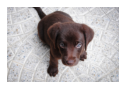

In [ ]:
im_t2 = cast(tensor(1), TensorMask)
test_eq(type(im_t2), TensorMask)
test_eq(im_t2, tensor(1))
ax = im_t.show(figsize=(2,2))
_ =(im_t == im_t2)

In [ ]:
test_fig_exists(ax)

Operations between `TensorMask` and `TensorImageBase` objects return the type of the `TensorImageBase` object:

In [ ]:
a = TensorMask([1,2])
test_eq_type(TensorImage(1)+a, TensorImage([2,3]))
test_eq_type(1-a, TensorMask([0,-1]))

In [ ]:
#hide (last test of to_concat)
test_eq_type(to_concat([TensorImage([1,2]), TensorImage([3,4])]), TensorImage([1,2,3,4]))

In [ ]:
#export
class TensorFlowField(TensorBase): pass
TensorImage.register_func(F.grid_sample, TensorImageBase, TensorFlowField)

In [ ]:
t1 = TensorImage([1.]).view(1,1,1,1)
t2 = TensorFlowField([1.,1.]).view(1,1,1,2)
test_eq_type(F.grid_sample(t1, t2), TensorImage([[[[0.25]]]]))

In [ ]:
#export 
class TensorCategory(TensorBase): pass

TensorBase.register_func(Tensor.__getitem__, TensorImageBase, TensorCategory)

In [ ]:
tc = TensorCategory([1,2,3])
mask_t = TensorMask([0,2,4,5])
im_t = TensorImage([0,2,4,5])
test_eq(mask_t[tc], tensor([2,4,5]))
test_eq(im_t[tc], tensor([2,4,5]))

In [ ]:
#export 
class TensorMultiCategory(TensorCategory): pass

In [ ]:
#export
class TitledTensorScalar(TensorBase):
    "A tensor containing a scalar that has a `show` method"
    def show(self, **kwargs): show_title(self.item(), **kwargs)

## L -

In [ ]:
#export
@patch
def tensored(self:L):
    "`mapped(tensor)`"
    return self.map(tensor)
@patch
def stack(self:L, dim=0):
    "Same as `torch.stack`"
    return torch.stack(list(self.tensored()), dim=dim)
@patch
def cat  (self:L, dim=0):
    "Same as `torch.cat`"
    return torch.cat  (list(self.tensored()), dim=dim)

In [ ]:
show_doc(L.tensored)

<h4 id="L.tensored" class="doc_header"><code>L.tensored</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>L.tensored</code>()

`mapped(tensor)`

There are shortcuts for `torch.stack` and `torch.cat` if your `L` contains tensors or something convertible. You can manually convert with `tensored`.

In [ ]:
t = L(([1,2],[3,4]))
test_eq(t.tensored(), [tensor(1,2),tensor(3,4)])

In [ ]:
show_doc(L.stack)

<h4 id="L.stack" class="doc_header"><code>L.stack</code><a href="__main__.py#L6" class="source_link" style="float:right">[source]</a></h4>

> <code>L.stack</code>(**`dim`**=*`0`*)

Same as `torch.stack`

In [ ]:
test_eq(t.stack(), tensor([[1,2],[3,4]]))

In [ ]:
show_doc(L.cat)

<h4 id="L.cat" class="doc_header"><code>L.cat</code><a href="__main__.py#L10" class="source_link" style="float:right">[source]</a></h4>

> <code>L.cat</code>(**`dim`**=*`0`*)

Same as `torch.cat`

In [ ]:
test_eq(t.cat(), tensor([1,2,3,4]))

## Chunks

In [ ]:
#export
def concat(*ls):
    "Concatenate tensors, arrays, lists, or tuples"
    if not len(ls): return []
    it = ls[0]
    if isinstance(it,torch.Tensor): res = torch.cat(ls)
    elif isinstance(it,ndarray): res = np.concatenate(ls)
    else:
        res = itertools.chain.from_iterable(map(L,ls))
        if isinstance(it,(tuple,list)): res = type(it)(res)
        else: res = L(res)
    return retain_type(res, it)

In [ ]:
a,b,c = [1],[1,2],[1,1,2]
test_eq(concat(a,b), c)
test_eq_type(concat(tuple (a),tuple (b)), tuple (c))
test_eq_type(concat(array (a),array (b)), array (c))
test_eq_type(concat(tensor(a),tensor(b)), tensor(c))
test_eq_type(concat(TensorBase(a),TensorBase(b)), TensorBase(c))
test_eq_type(concat([1,1],1), [1,1,1])
test_eq_type(concat(1,1,1), L(1,1,1))
test_eq_type(concat(L(1,2),1), L(1,2,1))

In [ ]:
#export
class Chunks:
    "Slice and int indexing into a list of lists"
    def __init__(self, chunks, lens=None):
        self.chunks = chunks
        self.lens = L(map(len,self.chunks) if lens is None else lens)
        self.cumlens = np.cumsum(0+self.lens)
        self.totlen = self.cumlens[-1]

    def __getitem__(self,i):
        if isinstance(i,slice): return retain_type(self.getslice(i), old=self.chunks[0])
        di,idx = self.doc_idx(i)
        return retain_type(self.chunks[di][idx], old=self.chunks[0])

    def getslice(self, i):
        st_d,st_i = self.doc_idx(ifnone(i.start,0))
        en_d,en_i = self.doc_idx(ifnone(i.stop,self.totlen+1))
        res = [self.chunks[st_d][st_i:(en_i if st_d==en_d else sys.maxsize)]]
        for b in range(st_d+1,en_d): res.append(self.chunks[b])
        if st_d!=en_d and en_d<len(self.chunks): res.append(self.chunks[en_d][:en_i])
        return concat(*res)

    def doc_idx(self, i):
        if i<0: i=self.totlen+i # count from end
        docidx = np.searchsorted(self.cumlens, i+1)-1
        cl = self.cumlens[docidx]
        return docidx,i-cl

In [ ]:
docs = L(list(string.ascii_lowercase[a:b]) for a,b in ((0,3),(3,7),(7,8),(8,16),(16,24),(24,26)))

b = Chunks(docs)
test_eq([b[ o] for o in range(0,5)], ['a','b','c','d','e'])
test_eq([b[-o] for o in range(1,6)], ['z','y','x','w','v'])
test_eq(b[6:13], 'g,h,i,j,k,l,m'.split(','))
test_eq(b[20:77], 'u,v,w,x,y,z'.split(','))
test_eq(b[:5], 'a,b,c,d,e'.split(','))
test_eq(b[:2], 'a,b'.split(','))

In [ ]:
t = torch.arange(26)
docs = L(t[a:b] for a,b in ((0,3),(3,7),(7,8),(8,16),(16,24),(24,26)))
b = Chunks(docs)
test_eq([b[ o] for o in range(0,5)], range(0,5))
test_eq([b[-o] for o in range(1,6)], [25,24,23,22,21])
test_eq(b[6:13], torch.arange(6,13))
test_eq(b[20:77], torch.arange(20,26))
test_eq(b[:5], torch.arange(5))
test_eq(b[:2], torch.arange(2))

In [ ]:
docs = L(TensorBase(t[a:b]) for a,b in ((0,3),(3,7),(7,8),(8,16),(16,24),(24,26)))
b = Chunks(docs)
test_eq_type(b[:2], TensorBase(range(2)))
test_eq_type(b[:5], TensorBase(range(5)))
test_eq_type(b[9:13], TensorBase(range(9,13)))

## Simple types

In [ ]:
#export
def show_title(o, ax=None, ctx=None, label=None, color='black', **kwargs):
    "Set title of `ax` to `o`, or print `o` if `ax` is `None`"
    ax = ifnone(ax,ctx)
    if ax is None: print(o)
    elif hasattr(ax, 'set_title'):
        t = ax.title.get_text()
        if len(t) > 0: o = t+'\n'+str(o)
        ax.set_title(o, color=color)
    elif isinstance(ax, pd.Series):
        while label in ax: label += '_'
        ax = ax.append(pd.Series({label: o}))
    return ax

In [ ]:
test_stdout(lambda: show_title("title"), "title")
# ensure that col names are unique when showing to a pandas series
assert show_title("title", ctx=pd.Series(dict(a=1)), label='a').equals(pd.Series(dict(a=1,a_='title')))

In [ ]:
#export
class ShowTitle:
    "Base class that adds a simple `show`"
    _show_args = {'label': 'text'}
    def show(self, ctx=None, **kwargs):
        "Show self"
        return show_title(str(self), ctx=ctx, **merge(self._show_args, kwargs))

class TitledInt(Int, ShowTitle):
    _show_args = {'label': 'text'}
    def show(self, ctx=None, **kwargs):
        "Show self"
        return show_title(str(self), ctx=ctx, **merge(self._show_args, kwargs))

class TitledFloat(Float, ShowTitle):
    _show_args = {'label': 'text'}
    def show(self, ctx=None, **kwargs):
        "Show self"
        return show_title(str(self), ctx=ctx, **merge(self._show_args, kwargs))

class TitledStr(Str, ShowTitle):
    _show_args = {'label': 'text'}
    def show(self, ctx=None, **kwargs):
        "Show self"
        return show_title(str(self), ctx=ctx, **merge(self._show_args, kwargs))

class TitledTuple(fastuple, ShowTitle):
    _show_args = {'label': 'text'}
    def show(self, ctx=None, **kwargs):
        "Show self"
        return show_title(str(self), ctx=ctx, **merge(self._show_args, kwargs))

add_docs(TitledInt, "An `int` with `show`"); add_docs(TitledStr, "An `str` with `show`");
add_docs(TitledFloat, "A `float` with `show`"); add_docs(TitledTuple, "A `fastuple` with `show`")

In [ ]:
show_doc(TitledInt, title_level=3)

<h3 id="TitledInt" class="doc_header"><code>class</code> <code>TitledInt</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>TitledInt</code>() :: [`Int`](https://fastcore.fast.ai/basics#Int)

An `int` with `show`

In [ ]:
show_doc(TitledStr, title_level=3)

<h3 id="TitledStr" class="doc_header"><code>class</code> <code>TitledStr</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>TitledStr</code>() :: [`Str`](https://fastcore.fast.ai/basics#Str)

An `str` with `show`

In [ ]:
show_doc(TitledFloat, title_level=3)

<h3 id="TitledFloat" class="doc_header"><code>class</code> <code>TitledFloat</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>TitledFloat</code>(**`x`**=*`0`*) :: [`Float`](https://fastcore.fast.ai/basics#Float)

A `float` with `show`

In [ ]:
test_stdout(lambda: TitledStr('s').show(), 's')
test_stdout(lambda: TitledInt(1).show(), '1')

In [ ]:
show_doc(TitledTuple, title_level=3)

<h3 id="TitledTuple" class="doc_header"><code>class</code> <code>TitledTuple</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>TitledTuple</code>(**`x`**=*`None`*, **\*`rest`**) :: [`fastuple`](https://fastcore.fast.ai/basics#fastuple)

A [`fastuple`](https://fastcore.fast.ai/basics#fastuple) with `show`

In [ ]:
#hide
df = pd.DataFrame(index = range(1))
row = df.iloc[0]
x = TitledFloat(2.56)
row = x.show(ctx=row, label='lbl')
test_eq(float(row.lbl), 2.56)

In [ ]:
#export
@patch
def truncate(self:TitledStr, n):
    "Truncate self to `n`"
    words = self.split(' ')[:n]
    return TitledStr(' '.join(words))

## Other functions

In [ ]:
#export
if not hasattr(pd.DataFrame,'_old_init'): pd.DataFrame._old_init = pd.DataFrame.__init__

In [ ]:
#export
@patch
def __init__(self:pd.DataFrame, data=None, index=None, columns=None, dtype=None, copy=False):
    if data is not None and isinstance(data, Tensor): data = to_np(data)
    self._old_init(data, index=index, columns=columns, dtype=dtype, copy=copy)

In [ ]:
#export
def get_empty_df(n):
    "Return `n` empty rows of a dataframe"
    df = pd.DataFrame(index = range(n))
    return [df.iloc[i] for i in range(n)]

In [ ]:
#export
def display_df(df):
    "Display `df` in a notebook or defaults to print"
    try: from IPython.display import display, HTML
    except: return print(df)
    display(HTML(df.to_html()))

In [ ]:
#export
def get_first(c):
    "Get the first element of c, even if c is a dataframe"
    return getattr(c, 'iloc', c)[0]

In [ ]:
#export
def one_param(m):
    "First parameter in `m`"
    return first(m.parameters())

In [ ]:
#export
def item_find(x, idx=0):
    "Recursively takes the `idx`-th element of `x`"
    if is_listy(x): return item_find(x[idx])
    if isinstance(x,dict):
        key = list(x.keys())[idx] if isinstance(idx, int) else idx
        return item_find(x[key])
    return x

In [ ]:
#export
def find_device(b):
    "Recursively search the device of `b`."
    return item_find(b).device

In [ ]:
t2 = to_device(tensor(0))
dev = default_device()
test_eq(find_device(t2), dev)
test_eq(find_device([t2,t2]), dev)
test_eq(find_device({'a':t2,'b':t2}), dev)
test_eq(find_device({'a':[[t2],[t2]],'b':t2}), dev)

In [ ]:
#export
def find_bs(b):
    "Recursively search the batch size of `b`."
    return item_find(b).shape[0]

In [ ]:
x = torch.randn(4,5)
test_eq(find_bs(x), 4)
test_eq(find_bs([x, x]), 4)
test_eq(find_bs({'a':x,'b':x}), 4)
test_eq(find_bs({'a':[[x],[x]],'b':x}), 4)

In [ ]:
#export
def np_func(f):
    "Convert a function taking and returning numpy arrays to one taking and returning tensors"
    def _inner(*args, **kwargs):
        nargs = [to_np(arg) if isinstance(arg,Tensor) else arg for arg in args]
        return tensor(f(*nargs, **kwargs))
    functools.update_wrapper(_inner, f)
    return _inner

This decorator is particularly useful for using numpy functions as fastai metrics, for instance:

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
@np_func
def f1(inp,targ): return f1_score(targ, inp)

a1,a2 = array([0,1,1]),array([1,0,1])
t = f1(tensor(a1),tensor(a2))
test_eq(f1_score(a1,a2), t)
assert isinstance(t,Tensor)

In [ ]:
#export
class Module(nn.Module, metaclass=PrePostInitMeta):
    "Same as `nn.Module`, but no need for subclasses to call `super().__init__`"
    def __pre_init__(self, *args, **kwargs): super().__init__()
    def __init__(self): pass

In [ ]:
show_doc(Module, title_level=3)

<h3 id="Module" class="doc_header"><code>class</code> <code>Module</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>Module</code>() :: [`Module`](/torch_core.html#Module)

Same as `nn.Module`, but no need for subclasses to call `super().__init__`

In [ ]:
class _T(Module):
    def __init__(self): self.f = nn.Linear(1,1)
    def forward(self,x): return self.f(x)

t = _T()
t(tensor([1.]))

tensor([-0.0832], grad_fn=<AddBackward0>)

In [ ]:
# export
from torch.nn.parallel import DistributedDataParallel

In [ ]:
# export
def get_model(model):
    "Return the model maybe wrapped inside `model`."
    return model.module if isinstance(model, (DistributedDataParallel, nn.DataParallel)) else model

In [ ]:
# export
def one_hot(x, c):
    "One-hot encode `x` with `c` classes."
    res = torch.zeros(c, dtype=torch.uint8)
    if isinstance(x, Tensor) and x.numel()>0: res[x] = 1.
    else: res[list(L(x, use_list=None))] = 1.
    return res

In [ ]:
test_eq(one_hot([1,4], 5), tensor(0,1,0,0,1).byte())
test_eq(one_hot(torch.tensor([]), 5), tensor(0,0,0,0,0).byte())
test_eq(one_hot(2, 5), tensor(0,0,1,0,0).byte())

In [ ]:
#export
def one_hot_decode(x, vocab=None):
    return L(vocab[i] if vocab else i for i,x_ in enumerate(x) if x_==1)

In [ ]:
test_eq(one_hot_decode(tensor(0,1,0,0,1)), [1,4])
test_eq(one_hot_decode(tensor(0,0,0,0,0)), [   ])
test_eq(one_hot_decode(tensor(0,0,1,0,0)), [2  ])

In [ ]:
#export
def params(m):
    "Return all parameters of `m`"
    return [p for p in m.parameters()]

In [ ]:
#export
def trainable_params(m):
    "Return all trainable parameters of `m`"
    return [p for p in m.parameters() if p.requires_grad]

In [ ]:
m = nn.Linear(4,5)
test_eq(trainable_params(m), [m.weight, m.bias])
m.weight.requires_grad_(False)
test_eq(trainable_params(m), [m.bias])

In [ ]:
#export
norm_types = (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d, nn.InstanceNorm1d, nn.InstanceNorm2d, nn.InstanceNorm3d, nn.LayerNorm)

In [ ]:
#export
def norm_bias_params(m, with_bias=True):
    "Return all bias and BatchNorm parameters"
    if isinstance(m, norm_types): return L(m.parameters())
    res = L(m.children()).map(norm_bias_params, with_bias=with_bias).concat()
    if with_bias and getattr(m, 'bias', None) is not None: res.append(m.bias)
    return res

In [ ]:
for norm_func in [nn.BatchNorm1d, partial(nn.InstanceNorm1d, affine=True)]:
    model = nn.Sequential(nn.Linear(10,20), norm_func(20), nn.Conv1d(3,4, 3))
    test_eq(norm_bias_params(model), [model[0].bias, model[1].weight, model[1].bias, model[2].bias])
    model = nn.ModuleList([nn.Linear(10,20, bias=False), nn.Sequential(norm_func(20), nn.Conv1d(3,4,3))])
    test_eq(norm_bias_params(model), [model[1][0].weight, model[1][0].bias, model[1][1].bias])
    model = nn.ModuleList([nn.Linear(10,20), nn.Sequential(norm_func(20), nn.Conv1d(3,4,3))])
    test_eq(norm_bias_params(model, with_bias=False), [model[1][0].weight, model[1][0].bias])

In [ ]:
#export
def batch_to_samples(b, max_n=10):
    "'Transposes' a batch to (at most `max_n`) samples"
    if isinstance(b, Tensor): return retain_types(list(b[:max_n]), [b])
    else:
        res = L(b).map(partial(batch_to_samples,max_n=max_n))
        return retain_types(res.zip(), [b])

In [ ]:
t = tensor([1,2,3])
test_eq(batch_to_samples([t,t+1], max_n=2), ([1,2],[2,3]))
test_eq(batch_to_samples(tensor([1,2,3]), 10), [1, 2, 3])
test_eq(batch_to_samples([tensor([1,2,3]), tensor([4,5,6])], 10), [(1, 4), (2, 5), (3, 6)])
test_eq(batch_to_samples([tensor([1,2,3]), tensor([4,5,6])], 2), [(1, 4), (2, 5)])
test_eq(batch_to_samples([tensor([1,2,3]), [tensor([4,5,6]),tensor([7,8,9])]], 10), 
        [(1, (4, 7)), (2, (5, 8)), (3, (6, 9))])
test_eq(batch_to_samples([tensor([1,2,3]), [tensor([4,5,6]),tensor([7,8,9])]], 2), [(1, (4, 7)), (2, (5, 8))])

t = fastuple(tensor([1,2,3]),TensorBase([2,3,4]))
test_eq_type(batch_to_samples(t)[0][1], TensorBase(2))
test_eq(batch_to_samples(t).map(type), [fastuple]*3)

In [ ]:
#export
@patch
def interp_1d(x:Tensor, xp, fp):
    "Same as `np.interp`"
    slopes = (fp[1:]-fp[:-1])/(xp[1:]-xp[:-1])
    incx = fp[:-1] - (slopes*xp[:-1])
    locs = (x[:,None]>=xp[None,:]).long().sum(1)-1
    locs = locs.clamp(0,len(slopes)-1)
    return slopes[locs]*x + incx[locs]

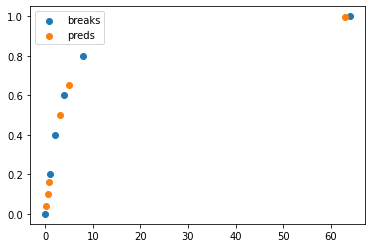

In [ ]:
brks = tensor(0,1,2,4,8,64).float()
ys = tensor(range_of(brks)).float()
ys /= ys[-1].item()
pts = tensor(0.2,0.5,0.8,3,5,63)

preds = pts.interp_1d(brks, ys)
test_close(preds.numpy(), np.interp(pts.numpy(), brks.numpy(), ys.numpy()))

plt.scatter(brks,ys)
plt.scatter(pts,preds)
plt.legend(['breaks','preds']);

In [ ]:
#export
@patch
def pca(x:Tensor, k=2):
    "Compute PCA of `x` with `k` dimensions."
    x = x-torch.mean(x,0)
    U,S,V = torch.svd(x.t())
    return torch.mm(x,U[:,:k])

In [ ]:
# export
def logit(x):
    "Logit of `x`, clamped to avoid inf."
    x = x.clamp(1e-7, 1-1e-7)
    return -(1/x-1).log()

In [ ]:
#export
def num_distrib():
    "Return the number of processes in distributed training (if applicable)."
    return int(os.environ.get('WORLD_SIZE', 0))

In [ ]:
#export
def rank_distrib():
    "Return the distributed rank of this process (if applicable)."
    return int(os.environ.get('RANK', 0))

In [ ]:
#export
def distrib_barrier():
    "Place a synchronization barrier in distributed training"
    if num_distrib() > 1 and torch.distributed.is_initialized(): torch.distributed.barrier()

After calling this, ALL sub-processes in the pytorch process group must arrive here before proceeding.

In [ ]:
#export
# Saving arrays requires pytables - optional dependency
try: import tables
except: pass

In [ ]:
#export
def _comp_filter(lib='lz4',lvl=3): return tables.Filters(complib=f'blosc:{lib}', complevel=lvl)

In [ ]:
#export
@patch
def save_array(p:Path, o, complib='lz4', lvl=3):
    "Save numpy array to a compressed `pytables` file, using compression level `lvl`"
    if isinstance(o,Tensor): o = to_np(o)
    with tables.open_file(p, mode='w', filters=_comp_filter(lib=complib,lvl=lvl)) as f: f.create_carray('/', 'data', obj=o)

Compression lib can be any of: blosclz, lz4, lz4hc, snappy, zlib or zstd.

In [ ]:
#export
@patch
def load_array(p:Path):
    "Save numpy array to a `pytables` file"
    with tables.open_file(p, 'r') as f: return f.root.data.read()

In [ ]:
#export
def base_doc(elt):
    "Print a base documentation of `elt`"
    name = getattr(elt, '__qualname__', getattr(elt, '__name__', ''))
    print(f'{name}{inspect.signature(elt)}\n{inspect.getdoc(elt)}\n')
    print('To get a prettier result with hyperlinks to source code and documentation, install nbdev: pip install nbdev')

In [ ]:
#export
def doc(elt):
    "Try to use doc form nbdev and fall back to `base_doc`"
    try:
        from nbdev.showdoc import doc
        doc(elt)
    except: base_doc(elt)

In [ ]:
#export
def nested_reorder(t, idxs):
    "Reorder all tensors in `t` using `idxs`"
    if isinstance(t, (Tensor,L)): return t[idxs]
    elif is_listy(t): return type(t)(nested_reorder(t_, idxs) for t_ in t)
    if t is None: return t
    raise TypeError(f"Expected tensor, tuple, list or L but got {type(t)}")

In [ ]:
x = tensor([0,1,2,3,4,5])
idxs = tensor([2,5,1,0,3,4])
test_eq_type(nested_reorder(([x], x), idxs), ([idxs], idxs))

y = L(0,1,2,3,4,5)
z = L(i.item() for i in idxs)
test_eq_type(nested_reorder((y, x), idxs), (z,idxs))

## Image helpers

In [ ]:
#export
def make_cross_image(bw=True):
    "Create a tensor containing a cross image, either `bw` (True) or color"
    if bw:
        im = torch.zeros(5,5)
        im[2,:] = 1.
        im[:,2] = 1.
    else:
        im = torch.zeros(3,5,5)
        im[0,2,:] = 1.
        im[1,:,2] = 1.
    return im

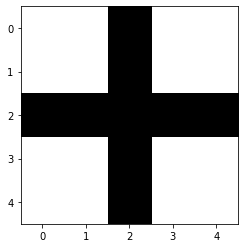

In [ ]:
plt.imshow(make_cross_image(), cmap="Greys");

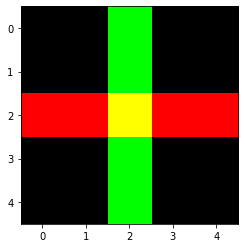

In [ ]:
plt.imshow(make_cross_image(False).permute(1,2,0));

In [ ]:
#export
def show_image_batch(b, show=show_titled_image, items=9, cols=3, figsize=None, **kwargs):
    "Display batch `b` in a grid of size `items` with `cols` width"
    if items<cols: cols=items
    rows = (items+cols-1) // cols
    if figsize is None: figsize = (cols*3, rows*3)
    fig,axs = plt.subplots(rows, cols, figsize=figsize)
    for *o,ax in zip(*to_cpu(b), axs.flatten()): show(o, ax=ax, **kwargs)

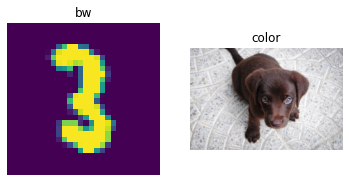

In [ ]:
show_image_batch(([Image.open(TEST_IMAGE_BW),Image.open(TEST_IMAGE)],['bw','color']), items=2)

## Model init

In [ ]:
#export
def requires_grad(m):
    "Check if the first parameter of `m` requires grad or not"
    ps = list(m.parameters())
    return ps[0].requires_grad if len(ps)>0 else False

In [ ]:
tst = nn.Linear(4,5)
assert requires_grad(tst)
for p in tst.parameters(): p.requires_grad_(False)
assert not requires_grad(tst)

In [ ]:
#export
def init_default(m, func=nn.init.kaiming_normal_):
    "Initialize `m` weights with `func` and set `bias` to 0."
    if func:
        if hasattr(m, 'weight'): func(m.weight)
        if hasattr(m, 'bias') and hasattr(m.bias, 'data'): m.bias.data.fill_(0.)
    return m

In [ ]:
tst = nn.Linear(4,5)
tst.weight.data.uniform_(-1,1)
tst.bias.data.uniform_(-1,1)
tst = init_default(tst, func = lambda x: x.data.fill_(1.))
test_eq(tst.weight, torch.ones(5,4))
test_eq(tst.bias, torch.zeros(5))

In [ ]:
#export
def cond_init(m, func):
    "Apply `init_default` to `m` unless it's a batchnorm module"
    if (not isinstance(m, norm_types)) and requires_grad(m): init_default(m, func)

In [ ]:
tst = nn.Linear(4,5)
tst.weight.data.uniform_(-1,1)
tst.bias.data.uniform_(-1,1)
cond_init(tst, func = lambda x: x.data.fill_(1.))
test_eq(tst.weight, torch.ones(5,4))
test_eq(tst.bias, torch.zeros(5))

tst = nn.BatchNorm2d(5)
init = [tst.weight.clone(), tst.bias.clone()]
cond_init(tst, func = lambda x: x.data.fill_(1.))
test_eq(tst.weight, init[0])
test_eq(tst.bias, init[1])

In [ ]:
#export
def apply_leaf(m, f):
    "Apply `f` to children of `m`."
    c = m.children()
    if isinstance(m, nn.Module): f(m)
    for l in c: apply_leaf(l,f)

In [ ]:
tst = nn.Sequential(nn.Linear(4,5), nn.Sequential(nn.Linear(4,5), nn.Linear(4,5)))
apply_leaf(tst, partial(init_default, func=lambda x: x.data.fill_(1.)))
for l in [tst[0], *tst[1]]: test_eq(l.weight, torch.ones(5,4))
for l in [tst[0], *tst[1]]: test_eq(l.bias,   torch.zeros(5))

In [ ]:
#export
def apply_init(m, func=nn.init.kaiming_normal_):
    "Initialize all non-batchnorm layers of `m` with `func`."
    apply_leaf(m, partial(cond_init, func=func))

In [ ]:
tst = nn.Sequential(nn.Linear(4,5), nn.Sequential(nn.Linear(4,5), nn.BatchNorm1d(5)))
init = [tst[1][1].weight.clone(), tst[1][1].bias.clone()]
apply_init(tst, func=lambda x: x.data.fill_(1.))
for l in [tst[0], tst[1][0]]: test_eq(l.weight, torch.ones(5,4))
for l in [tst[0], tst[1][0]]: test_eq(l.bias,   torch.zeros(5))
test_eq(tst[1][1].weight, init[0])
test_eq(tst[1][1].bias,   init[1])

## autograd jit functions

In [ ]:
#export
def script_use_ctx(f):
    "Decorator: create jit script and pass everything in `ctx.saved_variables to `f`, after `*args`"
    sf = torch.jit.script(f)
    def _f(ctx, *args, **kwargs): return sf(*args, *ctx.saved_variables, **kwargs)
    return update_wrapper(_f,f)

In [ ]:
#export
def script_save_ctx(static, *argidx):
    "Decorator: create jit script and save args with indices `argidx` using `ctx.save_for_backward`"
    def _dec(f):
        sf = torch.jit.script(f)
        def _f(ctx, *args, **kwargs):
            if argidx:
                save = [args[o] for o in argidx]
                ctx.save_for_backward(*save)
            if not argidx: args = [ctx]+args
            return sf(*args, **kwargs)
        if static: _f = staticmethod(_f)
        return update_wrapper(_f,f)
    return _dec

In [ ]:
#export
def script_fwd(*argidx):
    "Decorator: create static jit script and save args with indices `argidx` using `ctx.save_for_backward`"
    return script_save_ctx(True, *argidx)

In [ ]:
#export
def script_bwd(f):
    "Decorator: create static jit script and pass everything in `ctx.saved_variables to `f`, after `*args`"
    return staticmethod(script_use_ctx(f))

In [ ]:
#export
def grad_module(cls):
    "Decorator: convert `cls` into an autograd function"
    class _c(nn.Module):
        def forward(self, *args, **kwargs): return cls.apply(*args, **kwargs)
    return _c

# Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_torch_core.ipynb.
Converted 01_layers.ipynb.
Converted 01a_losses.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 04_data.external.ipynb.
Converted 05_data.transforms.ipynb.
Converted 06_data.block.ipynb.
Converted 07_vision.core.ipynb.
Converted 08_vision.data.ipynb.
Converted 09_vision.augment.ipynb.
Converted 09b_vision.utils.ipynb.
Converted 09c_vision.widgets.ipynb.
Converted 10_tutorial.pets.ipynb.
Converted 10b_tutorial.albumentations.ipynb.
Converted 11_vision.models.xresnet.ipynb.
Converted 12_optimizer.ipynb.
Converted 13_callback.core.ipynb.
Converted 13a_learner.ipynb.
Converted 13b_metrics.ipynb.
Converted 14_callback.schedule.ipynb.
Converted 14a_callback.data.ipynb.
Converted 15_callback.hook.ipynb.
Converted 15a_vision.models.unet.ipynb.
Converted 16_callback.progress.ipynb.
Converted 17_callback.tracker.ipynb.
Converted 18_callback.fp16.ipynb.
Converted 18a_callback.training.ipynb.
Converted 18b_callback.preds.ipynb.
Converted 